## Extracting Dihedral Angles at Triple Junctions from Segmentation Stacks

### Prep

In [2]:
### Imports

import itertools
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from skimage import io
from scipy import spatial
from scipy import interpolate

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

In [4]:
### Load input

im = io.imread('../../Generated/three_intersecting_spheres_aniso.tif')
print(im.dtype, im.shape)

uint8 (200, 400, 400)


In [5]:
### Show input segmentations

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Object Outlines

In [6]:
### Identify outlines by comparing shifted images

# Pad the image by 1 voxel on all sides
im_pad = np.pad(im, 1, mode='reflect')

# Get possible shifts in all directions
shifts = itertools.product([0,1], repeat=3)

# Check and accumulate differences in shifts
outlines = np.zeros_like(im, dtype=np.bool)
for shift in shifts:
    zs0, ys0, xs0 = [slice(1, None) if s else slice(None) for s in shift]
    zs1, ys1, xs1 = [slice(None,-1) if s else slice(None) for s in shift]
    comparison = im_pad[zs0, ys0, xs0] != im_pad[zs1, ys1, xs1]
    outlines  += comparison[:im.shape[0],  :im.shape[1],  :im.shape[2]]
    outlines  += comparison[-im.shape[0]:, -im.shape[1]:, -im.shape[2]:]  # Symmetry
    
# Re-annotate the cell identities
outlines_id = outlines * im

# Report
print(outlines.dtype, outlines.shape)
print(outlines_id.dtype, outlines_id.shape)

bool (200, 400, 400)
uint8 (200, 400, 400)


In [7]:
### Show identified outlines

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Triple Edges and Triple Junctions

In [10]:
### Find coordinates of all voxels involved in triple junctions

# Get coordinates of all cell outline voxels
OCs = np.array(np.where(outlines)).T  # OCs <- "Outline Coordinates"

# Go through outline coordinates (oc) and find TEs
def aroundArray(array,index1,index2,index3):
    tempList = []
    for x in range(index1-1,index1+2):
        for w in range(index2-1,index2+2):
            for q in range(index3-1,index3+2):
                tempList.append(array[x][w][q])
    return tempList
TEs =[]  # TEs <- "Triple Edes"
dictInterfaces={}
for index, OC in enumerate(OCs):
    sublist=aroundArray(im,OC[0],OC[1],OC[2])
    setInterfaces=tuple(set(sublist))
    if(setInterfaces in dictInterfaces):
        dictInterfaces[setInterfaces].append(index)
    else:
        dictInterfaces[setInterfaces]=[index]
    
    selection = im_pad[OC[0]+1:OC[0]+3, OC[1]+1:OC[1]+3, OC[2]+1:OC[2]+3]
    if len(set(selection.flatten())) == 3:
        TEs.append(OC+0.5)
        
# Convert TE list to numpy array
TEs = np.array(TEs)

In [11]:
### Build a dict of TJs structured as: {tuple(cell1_ID, cell2_ID, cell3_ID) : array(TEs, Dimensions)}

# Prepare defaultdict
from collections import defaultdict
TJs = defaultdict(lambda : [[],[],[]])  # TJs <- "Triple Junctions"

# Go through TEs, create IDs, assign coordinates to IDs
for TE in TEs:
    selection = im_pad[np.int(TE[0])+1:np.int(TE[0])+3, 
                       np.int(TE[1])+1:np.int(TE[1])+3, 
                       np.int(TE[2])+1:np.int(TE[2])+3]
    TJ_ID = tuple(sorted(set(selection.flatten())))
    TJs[TJ_ID][0].append(TE[0])
    TJs[TJ_ID][1].append(TE[1])
    TJs[TJ_ID][2].append(TE[2])

# Convert TJ lists to numpy arrays
for key in TJs.keys():
    TJs[key] = np.array(TJs[key]).T

In [12]:
### Show identified TJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get the TJs TEs in the selected z plane
        TEs_in_plane = TJs[TJ_ID][np.floor(TJs[TJ_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(TEs_in_plane[:, 2], TEs_in_plane[:, 1],
                    c=[TJ_num for _ in range(TEs_in_plane.shape[0])], 
                    cmap='hsv', vmin=0, vmax=len(TJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

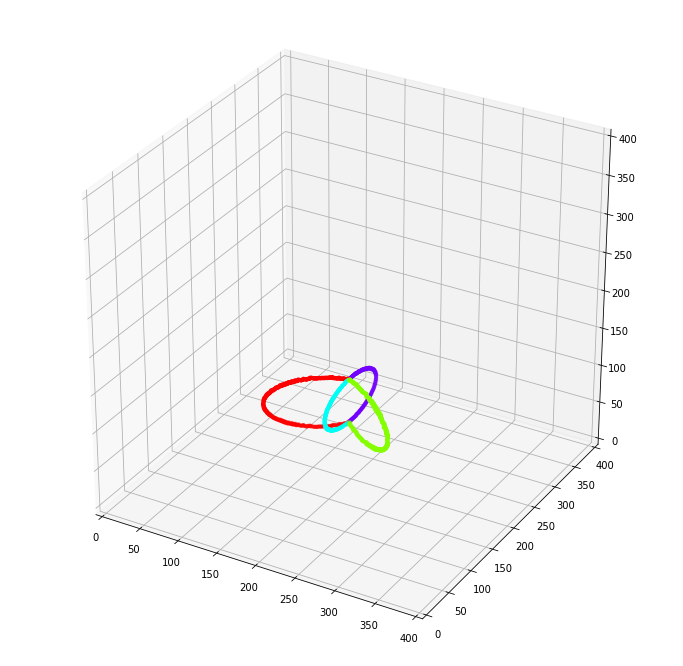

In [28]:
### Show identified TJs as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TJs[TJ_ID][:,2], TJs[TJ_ID][:,1], TJs[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Also show cell outlines [takes several seconds to render!]
#ax.scatter([c[2] for c in OCs],
#           [c[1] for c in OCs],
#           [c[0] for c in OCs],
#           c='gray', alpha=0.05, linewidth=0, s=5)

# Axis limits
ax.set_xlim([0,400])
ax.set_ylim([0,400])
ax.set_zlim([0,400])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

### Fitting Splines to TJs

*Turns out spline fitting requires the input points to be roughly in order along the spline, which isn't guaranteed in our case. Ordering the points happens to be far harder problem than one might imagine (it's a variation of traveling salesman) but luckily it can be solved quite well with a Breadth-First Search (BFS). This solution is partially inspired by Imanol Luengo's answer to [this SO question](https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line).*

In [29]:
### Function to reorder TEs along the progression of the TJ

def sort_line_coords(coords, N_neighbors=10, source=None, argsort=False):
    """Given a set of coordinates that roughly lie on a 1D curve in mD space
    (but may be in random order), sort the points such that they roughly follow 
    the curve's progression.
    
    Uses a breadth-first search tree on a nearest-neighbor graph of the coords,
    which happens to result in the best possible sort. 
    
    Parameters
    ----------
    coords : array of shape (N_points, M_dimensions)
        Coordinates of points roughly lying on a point in M-dimensional space.
    N_neighbors : int, optional, default 10
        Number of nearest neighbors to include for each graph. If this is set
        too low, connected components may form and no complete solution is
        possible (raises an Exception). If this is set too high, the resulting
        sort is very imprecises. The ideal value must be determined empirically.
        When used to prepare TJs for spline fitting in the context of pyCFI, the
        default (10) is a reasonably choice and the outcome is largely robust
        to changes between values of 5 and 20.
    source : None or int, optional, default None
        The source is a point at one of the two ends of the line. If None, the
        point is automatically determined by testing all different points and 
        selecting the one that yields the best sort (by minimizing the resulting
        path distance). If source is an int, it indexes into coords to specify
        the end point from which the sort is constructed. This saves a lot of
        time compared to the automated search, especially if there are many
        points, however it requires prior knowledge of the end point.
    argsort : bool, optional, default False
        If True, the index array that sorts the points into the best order is 
        returned. Otherwise, a sorted version of coords is returned.
    
    Returns
    -------
    sorted_coords : array of shape (N_points, M_dimensions)
        The same set of points as in the input coords but sorted along the
        curve's progression in space. Only returned if argsort is set to False.
    best_path : array of shape (N_points,)
        Index array that sorts points along the curve's progression in space. 
        Only returned if argsort is set to True.
    """
    
    # Get pairwise distances (if needed)
    if source is None:
        dists = spatial.distance.squareform(spatial.distance.pdist(coords))
    
    # Get nearest neighbors
    kdtree  = spatial.cKDTree(coords)
    _, KNNs = kdtree.query(coords, k=N_neighbors)
    
    # Build adjacency matrix
    adj_M = np.zeros((coords.shape[0], coords.shape[0]), dtype=np.bool)
    for i,N in enumerate(KNNs):
        adj_M[i,N] = True
    
    # Construct networkx graph
    G = nx.from_numpy_array(adj_M)
    if not nx.is_connected(G):
        raise Exception('sort_line_coords: adjacency graph is not fully connected!')
        
    # If a source node is given, just get its BFS tree
    if source is not None:
        best_path = list(nx.bfs_tree(G, source))
        
    # Otherwise, find the best BFS tree from all sources
    if source is None:
        paths = []
        costs = []
        for n in G.nodes():

            # Get BFS tree
            path = list(nx.bfs_tree(G, n))

            # Get sum of all distances within tree
            cost = 0.0
            for n0,n1 in zip(path, path[1:]):
                cost += dists[n0, n1]

            # Keep results
            paths.append(path)
            costs.append(cost)

        # Select the best solution
        best_path = paths[np.argmin(costs)]
    
    # Sort coords and return
    if argsort:
        return best_path
    else:
        return coords[best_path]

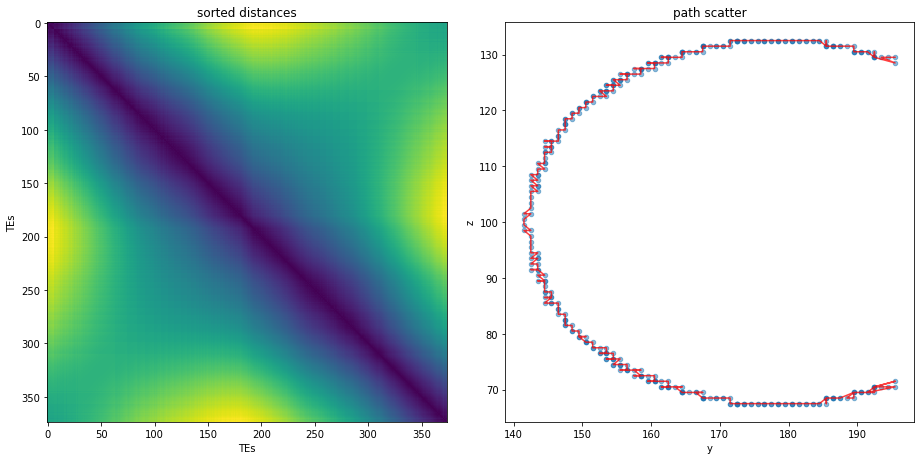

In [30]:
### A quick test of the TJ sorting

# Grab TJ and compute sort
TJ = TJs[list(TJs.keys())[0]]
sorted_TJ = sort_line_coords(TJ)

# Get sorted pairwise distances
sorted_dists = spatial.distance.squareform(spatial.distance.pdist(sorted_TJ))

# Plot pairwise distances
fig, ax = plt.subplots(1, 2, figsize=(13,6.5))
ax[0].imshow(sorted_dists)
ax[0].set_title("sorted distances")
ax[0].set_xlabel('TEs'); ax[0].set_ylabel('TEs')

# Plot path/tree on scatter
ax[1].scatter(TJ[:,1], TJ[:,0], s=20, alpha=0.5)
ax[1].plot(sorted_TJ[:,1], sorted_TJ[:,0], c='r', alpha=0.75)
ax[1].set_title("path scatter")
ax[1].set_xlabel('y'); ax[1].set_ylabel('z')

# Done
plt.tight_layout()
plt.show()

In [31]:
### Wrapper for spline fitting; allows handling exceptions

def wrap_splprep(coords, k=3, verbose=False):
    
    # Fit the spline and unpack the (weirdly packaged) results
    tcku, fp, ier, msg = interpolate.splprep(coords.T, k=k, full_output=True)
    tck, u = tcku

    # Report the results
    if verbose:
        print ('\nt (knots, tck[0]):\n' , tck[0])
        print ('\nc (coefficients, tck[1]):\n' , tck[1])
        print ('\nk (degree, tck[2]):' , tck[2])
        print ('\nu (evaluation points):\n', u)
        print ('\nfp (residual error):', fp)
        print ('\nier (error code; success is ier<=0):', ier)
        print ('\nmsg (message from FITPACK):\n', msg)
        
    # Raise an error if FITPACK indicates failure
    if ier > 0:
        raise Exception('ier is >0, indicating that FITPACK failed somehow. '+
                        'The message from FITPACK was:\n'+msg)
        
    # Return the only result relevant to spline evaluation
    return tck

In [32]:
### Perform sorting and spline fitting on all TJs

TJs_spltck = {}
TJs_splev  = {}
TJs_splevD = {} # Evaluation at same points with slight delta; used for normal vectors
for TJ_ID in TJs.keys():
    
    # Sort coords along the line
    TJs[TJ_ID] = sort_line_coords(TJs[TJ_ID])
    
    # Perform spline fitting
    tck = wrap_splprep(TJs[TJ_ID])
    TJs_spltck[TJ_ID] = tck
    
    # Evaluate the spline along regular intervals
    ev  = interpolate.splev(np.linspace(0.0, 1.0, 100), tck)
    evD = interpolate.splev(np.linspace(0.0, 1.0, 100)+10e-6, tck)
    TJs_splev[TJ_ID]  = np.array(ev).T
    TJs_splevD[TJ_ID] = np.array(evD).T

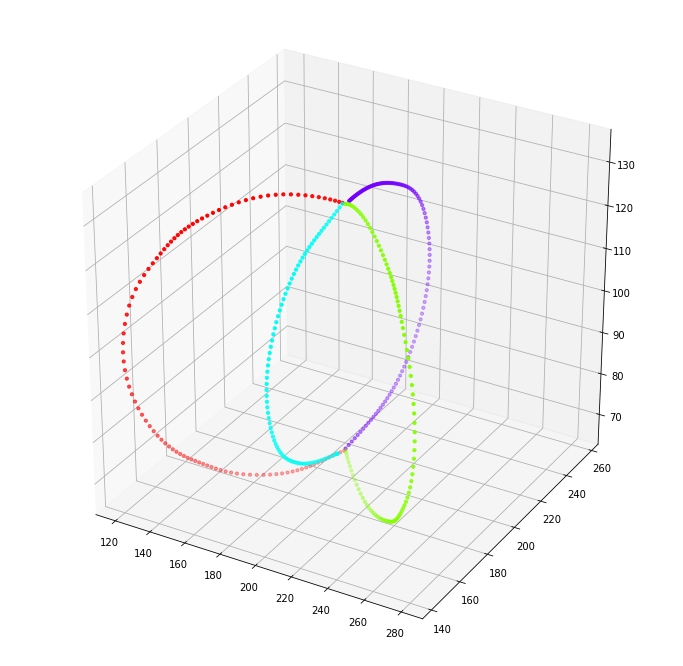

In [18]:
### Visualize the fitted splines as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ spline in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TJs_splev[TJ_ID][:,2], 
               TJs_splev[TJ_ID][:,1], 
               TJs_splev[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs_splev[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Axis limits
#ax.set_xlim([0,400])
#ax.set_ylim([0,400])
#ax.set_zlim([0,400])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

### Retrieving Incident Vectors (Our Approach)

Instead of first computing incident vectors for each TE in the image sectioning planes and then projecting them onto the corresponding orthogonal plane, we here attempt to compute the incident vectors directly based on the outline points close to said orthogonal plane.

In [41]:
### Sympy function to project close-by outline points onto a TE's orthogonal plane
### Note: this should be encoded so it doesn't need to be run by the end user!

# Import sympy stuff
import sympy as sym
from sympy.abc import q,r,s,  x,y,z  # (normal vector), (point to be projected)

# Use Gram-Schmidt orthogonalization to create orthonormal vectors defining the in-plane
# coordinate system given three arbitrary vectors, the first of which is the normal vector
# of the plane. The other two (defining the in-plane directionalities) are arbitrarily 
# chosen such that they will never fall onto the normal vector or onto each other.
orthonormals = sym.GramSchmidt([sym.Matrix([q,    r,  s]),  # Normal vector to plane -> first coordinate vector
                                sym.Matrix([q,  2*r,3*s]),  # Arbitrary vector not on the normal vector
                                sym.Matrix([2*q,3*r,  s])], # Arbitrary vector not on either other vector
                                orthonormal=True)           # Normalize resulting orthogonal vectors

# With the orthonormals defining the new coordinate system, the projection of points
# into it is just a straightforward dot product.
projection=x,y,z
for a in dictInterfaces:
    for b in dictInterfaces[a]:
        
        if (OCs[b]==[x,y,z]).all():
            interface=a  #interface the projected point is along 

projection_pt = sym.Matrix([x, y, z])

proj_d = orthonormals[0].dot(projection_pt)  # Distance from plane
proj_u = orthonormals[1].dot(projection_pt)  # Coordinate along first axis in plane
proj_v = orthonormals[2].dot(projection_pt)  # Coordinate along second axis in plane
# Lambdify
lambda_dist = sym.utilities.lambdify((q,r,s,x,y,z), proj_d, modules='numpy')
lambda_u    = sym.utilities.lambdify((q,r,s,x,y,z), proj_u, modules='numpy')
lambda_v    = sym.utilities.lambdify((q,r,s,x,y,z), proj_v, modules='numpy')
lambda_interface= sym.utilities.lambdify((q,r,s,x,y,z), interface, modules='numpy')



# Wrap
def p2p_projection(normal_vec, pt_coords):
    
    # Unpack inputs
    q,r,s = normal_vec[0], normal_vec[1], normal_vec[2]
    z,y,x = pt_coords[:,0], pt_coords[:,1], pt_coords[:,2]
    
    # Run projection
    dists = np.abs(lambda_dist(q,r,s,x,y,z))
    p_u   = lambda_u(q,r,s,x,y,z)
    p_v   = lambda_v(q,r,s,x,y,z)
    interfaces=lambda_interface(q,r,s,x,y,z)
    # Pack and return outputs
    projected = np.array([p_u, p_v]).T
    return projected, dists, interfaces

In [42]:
### Function to fit incident vectors for a TE

# TODO!

In [43]:
### Perform incident vector fitting for all TEs

# Parameters
query_range = 20
interfaces=[]
# Prep KDTree
kdtree = spatial.cKDTree(OCs)

# For each TJ...
for TJ_ID in TJs.keys():
    
    # Grab the TE
    TJ = TJs_splev[TJ_ID]
    
    # Get normal vectors for each TE plane
    normal_vecs = TJs_splevD[TJ_ID] - TJ
    
    # Get close-by points for each TE
    SNNs = kdtree.query_ball_point(TJs_splev[TJ_ID], query_range)
    
                    
        
    
    # Project close-by points and fit vectors
    all_projected = []
    all_dists     = []
    all_interfaces=[]
    totalList=[]
    interfaceProjectedDict={}
    for normal_vec, SNN, TE in zip(normal_vecs, SNNs, TJ):
        
        # Grab coords and translate them such that the TE is at (0,0,0)
        SNN_coords = OCs[SNN] - TE
        
        
        
        # Project close-by points to the plane
        projected, dists, interfaces = p2p_projection(normal_vec, SNN_coords)
        all_projected.append(projected)
        all_dists.append(dists)
        all_interfaces.append(interfaces)
        for i in range(0,len(all_interfaces),1):
            
        
        # Fit the incident vectors
        # TODO!
    
    break

In [22]:
### Visualize view in plane

@interact(TE_num=(0,99,1), dist_thresh=(0,100,1))
def visualize_plane(TE_num=50, dist_thresh=50):

    # Prep
    plt.figure(figsize=(12,9))

    # Plot points
    tempList=[]
    for index, x in enumerate(interfaces):
        if (x==(0,1)).all():
            tempList.append(all_projected[index])
            
    dist_mask = all_dists[TE_num]<np.percentile(all_dists[TE_num], dist_thresh)
    plt.scatter(all_projected[TE_num][dist_mask,0], 
                all_projected[TE_num][dist_mask,1], 
                c=all_dists[TE_num][dist_mask],
                s=20, alpha=0.8, linewidth=0)
    plt.colorbar(label='distance')

    # Mark origin
    plt.scatter(0, 0, c='r', s=100, linewidth=0)

    # Label
    plt.xlabel('u')
    plt.ylabel('v')

    # Done
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=50, description='TE_num', max=99), IntSlider(value=50, description='dist…

In [23]:
### Visualize in 3D context

@interact(TE_num=(0,99,1))
def visualize_plane(TE_num=50):

    # Prepare the plot
    fig = plt.figure(figsize=(12,12))
    ax  = fig.add_subplot(111, projection='3d')

    # Plot each TJ spline in a different color
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        ax.scatter(TJs_splev[TJ_ID][:,2], 
                   TJs_splev[TJ_ID][:,1], 
                   TJs_splev[TJ_ID][:,0],
                   c=[TJ_num for _ in range(TJs_splev[TJ_ID].shape[0])], 
                   cmap='hsv', vmin=0, vmax=len(TJs), s=10)

    ## Also show cell outlines [takes a few seconds to render!]
    #ax.scatter([c[2] for c in OCs],
    #           [c[1] for c in OCs],
    #           [c[0] for c in OCs],
    #           c='gray', alpha=0.05, linewidth=0, s=5)

    # Show the selected points
    ax.scatter(OCs[SNNs[TE_num],2], OCs[SNNs[TE_num],1], OCs[SNNs[TE_num],0],
               c='green', alpha=0.5, linewidth=0, s=5)

    ## Axis limits
    #ax.set_xlim([0,400])
    #ax.set_ylim([0,400])
    #ax.set_zlim([0,400]) 

    # Finish
    plt.show()

interactive(children=(IntSlider(value=50, description='TE_num', max=99), Output()), _dom_classes=('widget-inte…

### Next Up / To Do

- Our approach
    - Label/select the plane-projected points based on the interface they belong to [->> Vivek]
    - Fit a line/spline/arc through each set of projected interface points


- Brodland approach
    - Fit splines to each (relevant) outline in each z-slice [->> Harsh]
        - Only run this for each relevant TE in a given z-slice
        - Speed up pre-spline sorts by using the TEs as source points
    - Use the splines to get angles/vectors for TEs
    - Project the resulting vectors onto the corresponding normal planes
    

- Both approaches
    - Look at the resulting set of angles/vectors and see how to consolidate/average them (whilst enforcing consistency)
        - Truncate endings, as they are often messy
        - Entirely trash very short TJs (do this early on)
        - Look at the remaining angles/vectors and see how best to clean/average them
        - Consider using the residuals from the line/spline/arc fits somehow to weigh contributions
    - Proceed to use the resulting angles/vectors for equation solving